In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Step 1: Visualize the time series

Read in moviedata.csv file

In [2]:
data = pd.read_csv("moviedata.csv")
data.head()

,Month,Total Gross,% Of Year,Avg.,Top Movie of the Month,Gross,% Of Total
0,1/1/2000,591410000,8%,"$3,969,195",Stuart Little,"$51,424,419",9%
1,2/1/2000,511350000,7%,"$3,277,885",Scream 3,"$79,050,098",15%
2,3/1/2000,511830000,7%,"$2,812,253",Erin Brockovich,"$66,216,976",13%
3,4/1/2000,524030000,7%,"$2,994,457",Rules of Engagement,"$50,228,672",10%
4,5/1/2000,637500000,8%,"$3,863,636",Gladiator (2000),"$129,437,265",20%


Clean column titles and change datatype

In [3]:
data.columns = ['Month', 'Total_Gross', 'Pct_Of_Year', 'Avg',
       'Top_Movie_of_the_Month ', 'Gross', 'Pct_Of_Total']
data.Month = pd.to_datetime(data.Month)
data.head()

,Month,Total_Gross,Pct_Of_Year,Avg,Top_Movie_of_the_Month,Gross,Pct_Of_Total
0,2000-01-01,591410000,8%,"$3,969,195",Stuart Little,"$51,424,419",9%
1,2000-02-01,511350000,7%,"$3,277,885",Scream 3,"$79,050,098",15%
2,2000-03-01,511830000,7%,"$2,812,253",Erin Brockovich,"$66,216,976",13%
3,2000-04-01,524030000,7%,"$2,994,457",Rules of Engagement,"$50,228,672",10%
4,2000-05-01,637500000,8%,"$3,863,636",Gladiator (2000),"$129,437,265",20%


The above plot is against the index, let's plot against the datetime:

Let's make the index the datetime

In [4]:
data.index = data.Month
data.drop(["Month"], axis=1, inplace=True)
data.head()

,Total_Gross,Pct_Of_Year,Avg,Top_Movie_of_the_Month,Gross,Pct_Of_Total
Month,,,,,,
2000-01-01,591410000,8%,"$3,969,195",Stuart Little,"$51,424,419",9%
2000-02-01,511350000,7%,"$3,277,885",Scream 3,"$79,050,098",15%
2000-03-01,511830000,7%,"$2,812,253",Erin Brockovich,"$66,216,976",13%
2000-04-01,524030000,7%,"$2,994,457",Rules of Engagement,"$50,228,672",10%
2000-05-01,637500000,8%,"$3,863,636",Gladiator (2000),"$129,437,265",20%


Plot Total Gross data

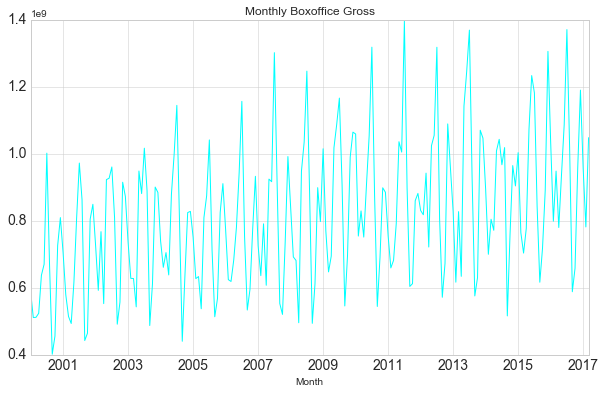

In [5]:
data.Total_Gross.plot(figsize=(10,6), title= 'Monthly Boxoffice Gross', fontsize=14, color='aqua')

# Step 2: Stationarize the series 

Check Stationarity
* constant mean
* constant variance
* autocovariance independent of time

Define a function for testing the mean and variance:

In [6]:
import matplotlib.pylab as plt

def test_stationarity(timeseries):
    #Determine rolling mean and standard dev
    rolling_mean = timeseries.rolling(window=12,center=False).mean()
    rolling_std = timeseries.rolling(window=12,center=False).std()
    
    #Plot statistics:
    window = plt.figure(figsize=(10, 6))
    series = plt.plot(timeseries, color = 'cyan', label='Series')
    mean = plt.plot(rolling_mean, color = 'fuchsia', label='Rolling Mean')
    std = plt.plot(rolling_std, color='lime', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    

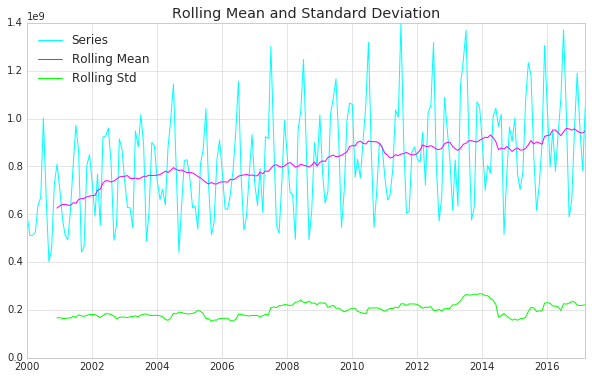

In [122]:
test_stationarity(data.Total_Gross)

Test different plots for stationarity:
* Log of gross sales
* First difference of gross sales
* First difference of log of gross sales
* Seasonal difference of gross sales
* Seasonal difference of log of gross sales

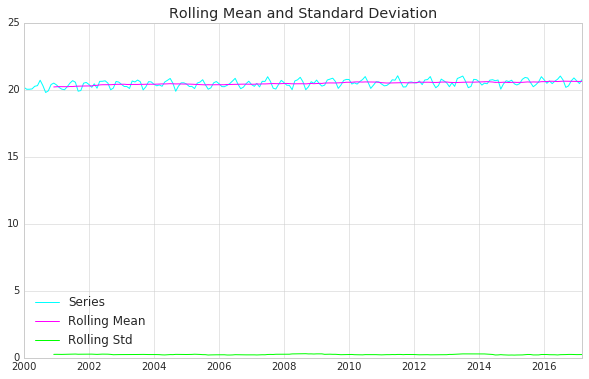

In [123]:
#log transform to penalizes higher values over small values
data.gross_log = data.Total_Gross.apply(lambda x: np.log(x))  
test_stationarity(data.gross_log)

For differencing, take the difference between an observation at t and at t-1

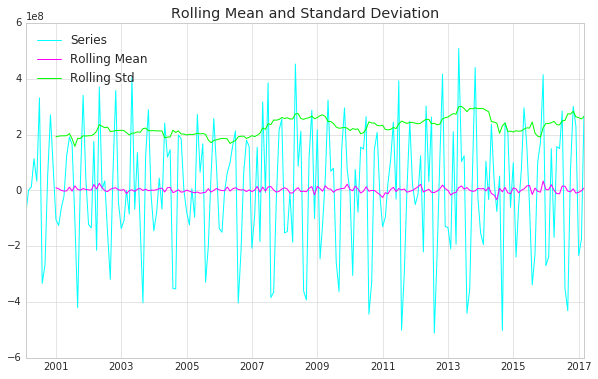

In [124]:
data.first_difference = data.Total_Gross - data.Total_Gross.shift(1)
test_stationarity(data.first_difference)

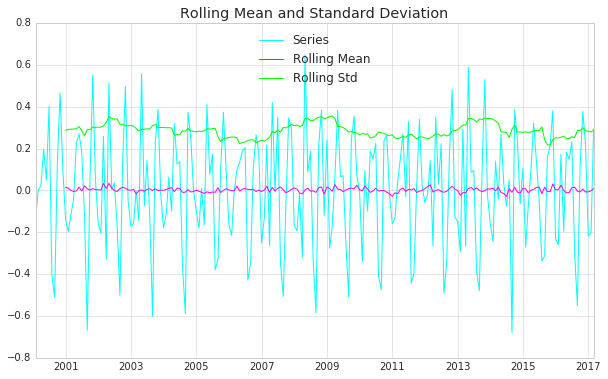

In [125]:
data.first_difference_log = data.gross_log - data.gross_log.shift(1)
test_stationarity(data.first_difference_log)

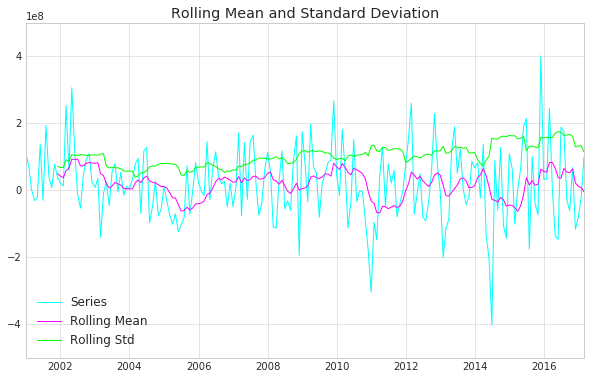

In [126]:
data.seasonal_difference = data.Total_Gross - data.Total_Gross.shift(12)
test_stationarity(data.seasonal_difference)

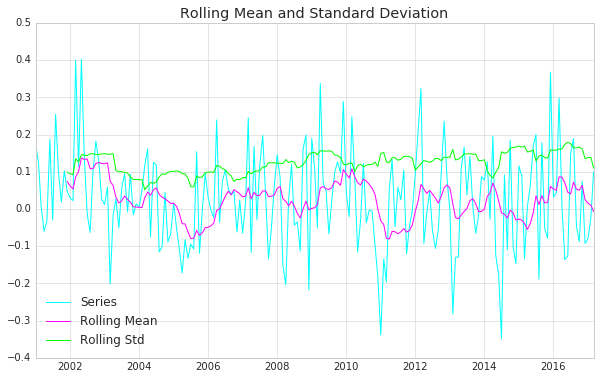

In [127]:
data.seasonal_difference_log = data.gross_log - data.gross_log.shift(12)
test_stationarity(data.seasonal_difference_log)

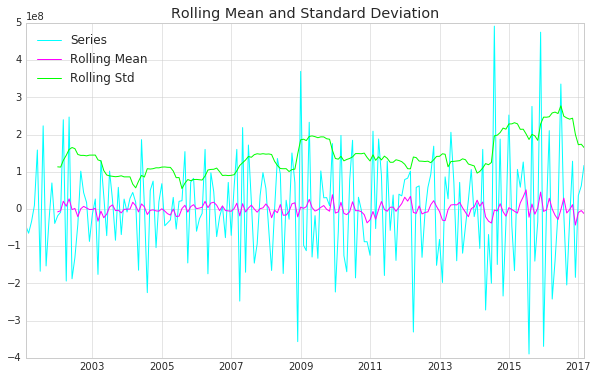

In [128]:
data.seasonal_first_difference = data.first_difference - data.first_difference.shift(12)
test_stationarity(data.seasonal_first_difference)

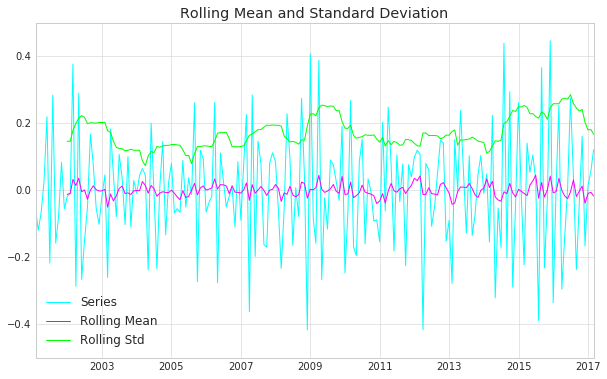

In [129]:
data.seasonal_first_difference_log = data.first_difference_log - data.first_difference_log.shift(12)
test_stationarity(data.seasonal_first_difference_log)

# Step 3: Plot ACF/PACF charts and find optimal parameters

ACF measures correlation of timeseries to a lagged version of itself i.e. t-12

In [27]:
data_acf = acf(data_diff, nlags=12)

PACF measures correlation of timeseries to a lagged version of itself i.e. t-12, after removing variations explained by timestampts in between

In [135]:
data_pacf = pacf(data_diff, nlags=12)

In [140]:
full_window = plt.figure(figsize=(12,8))
acf_window = fig.add_subplot(211)
acf_plot = sm.graphics.tsa.plot_acf(data.seasonal_first_difference_log.iloc[13:], lags=40, ax=acf_window)
pacf_window = fig.add_subplot(212)
pacf_plot = sm.graphics.tsa.plot_pacf(data.seasonal_first_difference_log.iloc[13:], lags=40, ax=pacf_window)

Based on these plots, choose p=1 and q=0

# Step 4: Build the SARIMA model

Create an SARIMA model where p=1 and q=0 and d=0 (number of non seasonal differences)

In [50]:
mod = sm.tsa.statespace.SARIMAX(df.riders, trend='n', order=(0,1,0), seasonal_order=(0,1,1,12))
results = mod.fit()
print results.summary()

Split test and train

In [47]:
size = int(len(data_diff)*0.66)
train = data_diff[0:size]
test = data[size:len(data_diff)]

In [52]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=0.119068, expected=0.268993
predicted=0.238767, expected=-0.030375
predicted=0.055746, expected=0.329825
predicted=0.229809, expected=-0.443632
predicted=-0.213602, expected=-0.395585
predicted=-0.412378, expected=0.013743
predicted=-0.105203, expected=0.339676
predicted=0.251079, expected=0.024957
predicted=0.116868, expected=-0.059441
predicted=-0.034873, expected=-0.015582
predicted=-0.027229, expected=0.141481
predicted=0.098966, expected=-0.266718
predicted=-0.150584, expected=0.349985
predicted=0.170554, expected=0.029972
predicted=0.127750, expected=0.222391
predicted=0.167001, expected=-0.491302
predicted=-0.274159, expected=-0.344195
predicted=-0.391321, expected=0.162924
predicted=0.011716, expected=0.481872
predicted=0.393751, expected=-0.126732
predicted=0.055367, expected=-0.148800
predicted=-0.142618, expected=-0.293331
predicted=-0.252374, expected=0.293827
predicted=0.122685, expected=-0.265965
predicted=-0.095345, expected=0.588916
predicted=0.318242, expecte

In [53]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

ValueError: ordinal must be >= 1

In [42]:
ARIMA_results = ARIMA_model.fit(disp=-1)

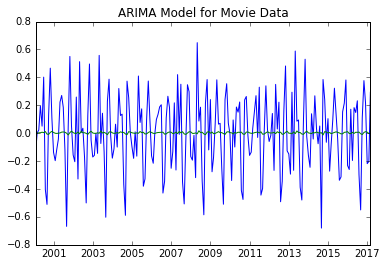

In [43]:
plt.plot(data_diff)
plt.plot(ARIMA_results.fittedvalues, color = 'green')
plt.title("ARIMA Model for Movie Data")

Replace lag

In [55]:
ARIMA_predictions = pd.Series(ARIMA_results.fittedvalues, copy=True)
ARIMA_predictions.head()

Month
2000-02-01    0.002796
2000-03-01   -0.000548
2000-04-01    0.002754
2000-05-01    0.003264
2000-06-01    0.007155
dtype: float64

In [56]:
ARIMA_predictions_cuml = ARIMA_predictions.cumsum()
ARIMA_predictions_cuml.head()

Month
2000-02-01    0.002796
2000-03-01    0.002248
2000-04-01    0.005002
2000-05-01    0.008267
2000-06-01    0.015421
dtype: float64

In [61]:
ARIMA_predictions_log = pd.Series(data_log.ix[0], index=data_log.index)
print ARIMA_predictions_log.head()
ARIMA_predictions_log = ARIMA_predictions.add(ARIMA_predictions_cuml, fill_value=0)
print ARIMA_predictions_log.head()
ARIMA_predictions_scaled = np.exp(ARIMA_predictions_log)
print ARIMA_predictions_scaled.head()

Month
2000-01-01    20.19802
2000-02-01    20.19802
2000-03-01    20.19802
2000-04-01    20.19802
2000-05-01    20.19802
dtype: float64
Month
2000-02-01    0.005592
2000-03-01    0.001700
2000-04-01    0.007756
2000-05-01    0.011531
2000-06-01    0.022576
dtype: float64
Month
2000-02-01    1.005608
2000-03-01    1.001701
2000-04-01    1.007787
2000-05-01    1.011598
2000-06-01    1.022833
dtype: float64


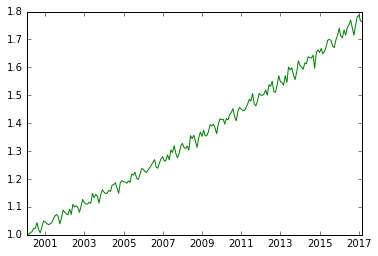

In [73]:
plt.close()
plt.plot(data.Total_Gross, color = "blue")
plt.plot(ARIMA_predictions_scaled, color = "green")

Diagnostic plots:
    * Standardized residuals
    * ACF of residuals
    * Normal QQ Plot of Std Residuals
    * P values for Ljung-Box statistic